# LDA: Topic Modelling with Latent Dirichlet Allocation

Gensim docs: https://radimrehurek.com/gensim/models/ldamodel.html

Gensim example: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Note: if Gensim on importing complains about BadZipFile: uninstall pattern

In [9]:
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import os
import pandas as pd
import re
import sys
import time
from IPython.display import clear_output

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [2]:
DATADIR = "../data/text/"
REPLY_ID = "in_reply_to_status_id_str"
MIN_TWEETS_PER_CONVERSATION = 5

def get_conversations(file_pattern, query, spy=False):
    tweets = []
    file_names = sorted(os.listdir(DATADIR))
    query_conversations = []
    for file_name in file_names:
        if re.search("^" + file_pattern, file_name):
            if spy:
                squeal(file_name)
            reply_ids = {}
            df = pd.read_csv(DATADIR+file_name, index_col=ID_STR, dtype=object)
            for i in range(0, len(df)):
                if not pd.isna(df.iloc[i][REPLY_ID]) and df.iloc[i][REPLY_ID] != "":
                    reply_id = df.iloc[i][REPLY_ID]
                    while reply_id in reply_ids:
                        reply_id = reply_ids[reply_id]
                    reply_ids[df.iloc[i].name] = { "reply_id": reply_id, "text": df.iloc[i][TEXT] }
            counts = {}
            for reply_id in reply_ids:
                while reply_ids[reply_id]["reply_id"] in reply_ids:
                    reply_ids[reply_id]["reply_id"] = reply_ids[reply_ids[reply_id]["reply_id"]]["reply_id"]
                if reply_ids[reply_id]["reply_id"] in counts:
                    counts[reply_ids[reply_id]["reply_id"]] += 1
                else:
                    counts[reply_ids[reply_id]["reply_id"]] = 1
            conversations = {}
            for reply_id in reply_ids:
                source_id = reply_ids[reply_id]["reply_id"]
                if counts[source_id] > MIN_TWEETS_PER_CONVERSATION:
                    if source_id in conversations:
                        conversations[source_id] += " "+reply_ids[reply_id]["text"]
                    else:
                        if source_id in df:
                            conversations[source_id] = df.loc[source_id][TEXT] + " " + reply_ids[reply_id]["text"]
                        else:
                            conversations[source_id] = reply_ids[reply_id]["text"]
            query_conversations.extend([conversations[conversation_id] 
                                        for conversation_id in conversations 
                                            if re.search(query, conversations[conversation_id], flags=re.IGNORECASE) and 
                                               re.search(IK_QUERY, conversations[conversation_id], flags=re.IGNORECASE)])
    return(query_conversations)


def tokenize_tweets(tweets, stop_words, spy=False):
    tokenized_tweets = []
    tokenized_tweets_with_stop_words = []
    seen = {}
    counter = 0
    for tweet in tweets:
        tokens = []
        tokens_with_stop_words = []
        for token in TweetTokenizer().tokenize(tweet):
            token = token.lower()
            tokens_with_stop_words.append(token)
            if token not in stop_words and not re.search("^http", token) and not re.search(r'^@', token):
                tokens.append(token)
        if len(tokens) > 0 and " ".join(tokens) not in seen:
            tokenized_tweets.append(" ".join(tokens))
            tokenized_tweets_with_stop_words.append(" ".join(tokens_with_stop_words))
            seen[" ".join(tokens)] = True
        if spy:
            counter += 1
            if counter % 100 == 0:
                squeal(f"{counter}/{len(tweets)}")
    return(tokenized_tweets, tokenized_tweets_with_stop_words)


def remove_nonwords(tokenized_tweets):
    words_in_tweets = []
    for i in range(0, len(tokenized_tweets)):
        tokens = []
        for token in tokenized_tweets[i].split():
            if len(token) > 1 and re.search("[a-z]", token):
                tokens.append(token)
        words_in_tweets.append(tokens)
    return(words_in_tweets)

In [3]:
BASEQUERY = "corona|covid"
UKRAINE_QUERY = "oekraine|oekraïne"
ID_STR = "id_str"
TEXT = "text"
HAPPY_QUERY = r'\b(geluk|gelukkig|gelukkige|blij|happy)\b'
LONELY_QUERY = r'eenza|alleen.*voel|voel.*alleen|lonely|loneli'
IK_QUERY = r'\b(ik|mij|mijn|me|mn|m\'n|zelf|mezelf|mijzelf|i)\b'

In [16]:
stop_words = ("aan aangezien absoluut achter af afgelopen al algemeen alle alleen allemaal allen alles als alsnog alsof altijd ander andere anders "
"antwoord april art augustus basis beeld beetje begin beginnen begint begrijp behalve beide bekend belangrijk ben benieuwd bent bepaalde "
"beperkt best beste betekent beter betreft bezig bij bijna bijv bijvoorbeeld blijf blijft blijkbaar blijkt blijven boven bovendien brengen buiten buurt "
"buurten compleet daadwerkelijk daar daarbij daardoor daarmee daarna daarnaast daarom daarvan daarvoor dacht dag dagen dan dat de december deel denk "
"denken denkt deze dezelfde die dingen direct dit doe doen doet door doordat drie duidelijk dus duurt echt echte echter edit een eens eerder eerlijk eerst "
"eerste eigen eigenlijk eind eindelijk elk elkaar elke en ene enige enkel enkele enorm er erg ergens erger ervan ervoor etc even extra februari fijn flink fout "
"ga gaan gaat gebeuren gebeurt gebruik gebruiken gebruikt gedaan geef geeft geen gegaan gegeven gehad gehouden gek geldt geleden gelijk gelukkig gemaakt genoeg genomen geval "
"geven gevoel gevolgen geweest gewoon geworden gezegd gezien ging gisteren goed goede gooi gooien graag groep groot grootste  grote groter haar had hadden halen half hard heb hebben "
"hebt heeft heel heen helaas hele helemaal helpt hem hen het hetzelfde hier hij hoe hoeft hoeveel hoeveelheid hoeven hoger hoog hoop hoor hopelijk hopen horen hou houd houden "
"houdt huidige hun idee ieder iedere iedereen iemand iets ik in inderdaad ineens informatie ingevoerd inmiddels ipv is ivm ja januari jaren je jezelf jij jonge "
"jou jouw juist juli jullie juni kan kans kant keer kijk kijken klaar klein kleine klinkt klopt kom komen komende komt kon kreeg krijg krijgen krijgt kun kunnen "
"kunt kwam laag laat laatste land landen lang lange langer langs last lastig laten later leer lees lekker letterlijk leven lezen liever liggen ligt lijken lijkt "
"logisch loopt lopen los m'n maak maakt maand maar maart mag maken makkelijk makkelijker man manier me mee meer meerdere meest meeste mei men mensen met "
"meteen middel mij mijn minder misschien mocht moeilijk moest moet moeten mogelijk mogen moment momenteel morgen na naar naast namelijk "
"natuurlijk nauwelijk nauwelijks nederland nederlander nederlanders nederlandse nee neem neemt nemen nergens net niemand niet niets nieuw nieuwe niks nl no "
"nodig nog nogal nooit normaal normale nou november nu of ofzo oktober om omdat on ondanks onder ondertussen ongeveer ons onze ooit ook op openlijk open over overal "
"overigens pa paar pakken pas per persoonlijk plek plekken praten precies prima probeer proberen punt qua raken redelijk relatief rest roepen rond samen september serieus simpelweg "
"sinds slechts snap snel sneller som sommige soms soort sowieso staan staat steed steeds stel stellen sterk strak straks stuk te tegen ten terecht terug "
"terwijl teveel the tijd tijden tijdens to toch toe toen tot totaal trouwens tussen twee u uit uiteindelijk uiteraard uur uw vaak vaker vallen valt van vanaf vandaag vanuit vanwege "
"vast vd veel velen ver verder verhaal verkeerd verplicht verschil verschillende vertrouwen vervolgens verwacht verwachten via vind vinden vindt voelt vol "
"voldoende volgen volgende volgens volledig vond voor vooral voorbij voordat voorkomen vorige vraag vrij vrijdag vrijwel vroeg vs waar waarbij waardoor waarin waarom "
"waarschijnlijk waarvan wachten wanneer want waren was wat we week weer weet weg weinig wel welke wellicht werd werden werken werkt weten wie wij wil willen "
"wilt woord word worden wordt x200b z'n zag zal zat ze zeer zeg zeggen zegt zei zeker zelf zelfs zetten zich zichzelf zie zien ziet zij zijn zin zit zitten zo zo'n "
"zoal zoals zodat zodra zoeken zolang zonder zorgen zorgt zou zouden zoveel zover zowel zullen zwaar één"
)

# covid stop words
# stop_words = (stop_words + " rt corona covid 19 covid19 coronavirus #corona #covid #covid19 #coronavirus").split()

# ukraine stop words
stop_words = (stop_words + " rt oorlog rusland oekraïne poetin putin oekraine russen russische eu geld jaar navo wapens wereld").split()

In [5]:
def process_month(month, query, nbr_of_passes=5, nbr_of_iterations=50, nbr_of_topics=20):
    tweets = [re.sub(r'\\n', ' ', tweet) for tweet in get_conversations(month, query, spy=False)]
    tokenized_tweets, tokenized_tweets_with_stop_words = tokenize_tweets(tweets, stop_words)
    tokenized_tweets_no_nonwords = remove_nonwords(tokenized_tweets)
    print(f"number of tweets: {len(tokenized_tweets_no_nonwords)}; number of unique tweets: {len([tweet for tweet in tokenized_tweets_no_nonwords if len(tweet) > 0])}; ")

    target_texts = tokenized_tweets_no_nonwords
    common_dictionary = Dictionary(target_texts)
    common_corpus = [common_dictionary.doc2bow(token_list) for token_list in target_texts if len(token_list) > 0]    
    lda = LdaMulticore(common_corpus, workers=3, passes=nbr_of_passes, iterations=nbr_of_iterations, num_topics=nbr_of_topics)
    top = lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)
    coherence_model_lda = CoherenceModel(model=lda, texts=target_texts, dictionary=common_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    top5score = sum([score for list_, score in top[:5]])/5 
    print(f"### {month} {coherence_score} {top5score}")
    for list_, score in top:
        print(score, end=" ")
        for id_ in list_:
            print(common_dictionary[int(id_[1])], end=" ")
        print()

For tips on how to tune the models, see https://highdemandskills.com/topic-modeling-lda/

In [17]:
for month in "202202".split():
    time_start = time.time()
    process_month(month, UKRAINE_QUERY, nbr_of_topics=5)
    print(f"computation took {int(time.time() - time_start)} seconds")

number of tweets: 9159; number of unique tweets: 9159; 
### 202202 0.3000183218221534 -1.6763646154617793
-1.5637076358769173 baudet thierry partij fvd dom #baudetlandverrader defensie volk tweet mannen democratie minister d66 kamer mens wef burgers rutte binnen landverrader 
-1.5988495461518135 rutte gas sjoerd volk betalen sancties europa bevolking wef burgers mark d66 baudet westen sturen kaag nato kabinet prijs regering 
-1.6924548279475582 europa democratie volk wef rutte partij partijen burgers klaver jesse leger d66 vuur der bevolking referendum olie kamer regering europese 
-1.7245381822193442 europa media westen biden corona nieuws trump bang propaganda binnen nato dom bevolking vluchtelingen amerika burgers volk waarheid onzin china 
-1.802272885113263 rutte baudet carnaval kinderen kamer vragen verkiezingen vieren nieuws thierry europa corona fvd mens wef dom media stemmen partij mooi 
computation took 5798.723903656006 seconds


In [15]:
for month in "202202".split():
    time_start = time.time()
    process_month(month, UKRAINE_QUERY, nbr_of_topics=5)
    print(f"computation took {int(time.time() - time_start)} seconds")

number of tweets: 9159; number of unique tweets: 9159; 
### 202202 0.3035051081762001 -1.5615790990262681
-1.4106047284833465 eu sjoerd navo rutte d66 jaar volk wereld gas europa geld burgers westen sancties wef democratie baudet partij dom wapens 
-1.4128801428731759 baudet thierry eu wef #baudetlandverrader fvd jaar kamer rutte navo wapens geld bevolking wereld kartel landverrader westen europa media volk 
-1.5363147390549126 eu navo europa democratie jaar partijen partij geld wef westen wereld leger klaver jesse volk bevolking wapens burgers der rutte 
-1.5532535169710322 rutte eu volk jaar europa navo wapens burgers wereld mark geld bevolking wef betalen gas vluchtelingen sancties westen trump biden 
-1.8948423677488742 wereld jaar dom eu media nieuws kinderen corona carnaval mannen geld tweet navo mens wapens binnen burgers domme vechten vieren 
computation took 4874.631744861603 seconds


In [6]:
for month in "202202".split():
    process_month(month, UKRAINE_QUERY)

number of tweets: 9159; number of unique tweets: 9159; 
### 202202 0.36275214917409754 -1.3155350817816274
-1.2236716891451802 rusland oekraïne poetin putin eu oorlog sancties navo jaar europa rutte baudet russen wereld wef volk russische westen oekraine binnen 
-1.2857557622372653 oorlog oekraïne eu poetin rusland defensie minister europa putin geld baudet wapens dom wereld volk jaar media navo rutte bevolking 
-1.3180064343157838 rusland poetin oekraïne oorlog putin eu wapens russische russen europa baudet wereld navo westen wef leger volk oekraine rutte fvd 
-1.3529594851112805 oorlog oekraïne rusland rutte eu volk betalen putin vrijheid prijs jaar poetin russen wapens wereld burgers defensie europa geld mooi 
-1.3972820380986275 oorlog rusland oekraïne rutte poetin putin eu navo europa russen wapens volk kaag d66 sjoerd biden westen jaar russische burgers 
-1.4089387809976301 eu oekraïne poetin rusland oorlog putin europa rutte d66 klimaat timmermans jaar navo wereld sancties volk 

In [7]:
for month in "202105 202106 202107 202108 202109 202110".split():
    process_month(month, BASEQUERY)

number of tweets: 12224; number of unique tweets: 12224; 
### 202105 0.4238672325919309 -1.7392349129504425
-1.6746267186749217 jaar vaccinatie vrijheid vaccin griep blij kinderen prik binnen mooi ziek rutte gevaccineerd virus vaccineren vorig thuis maatregelen zorg testen 
-1.7044349791482112 testen klachten ziek test miljoen geld mooi thuis rutte griep jaar vaccinatie maatregelen onzin overheid positief anderen hugo wereld werk 
-1.7119317010956778 test gratis vaccinatie jaar vaccin vaccineren vakantie ziek betalen testen virus geld volk angst onzin gevaccineerd blij dood anderen media 
-1.7772412658058263 vrijheid rutte israël jaar kaag palestijnen recht volk mark israel walgelijk joden burgers tweet wereld politiek hamas kinderen maatregelen oorlog 
-1.8279399000275756 fvd vaccin kamer partij baudet jaar haga thierry vrijheid politiek vaccinatie rutte ziek jammer vvd partijen wybren tweede vaccineren kabinet 
-1.844286295071456 vaccinatie boekje jaar vaccin gele prik testen test vi

In [5]:
nbr_of_passes = 5
nbr_of_iterations = 50
nbr_of_topics = 100
query = HAPPY_QUERY

for month in "202105".split():
    tweets = [re.sub(r'\\n', ' ', tweet) for tweet in get_conversations(month, query, spy=False)]
    tokenized_tweets, tokenized_tweets_with_stop_words = tokenize_tweets(tweets, stop_words)
    tokenized_tweets_no_nonwords = remove_nonwords(tokenized_tweets)
    print(f"number of tweets: {len(tokenized_tweets_no_nonwords)}; number of unique tweets: {len([tweet for tweet in tokenized_tweets_no_nonwords if len(tweet) > 0])}; ")

    target_texts = tokenized_tweets_no_nonwords
    common_dictionary = Dictionary(target_texts)
    common_corpus = [common_dictionary.doc2bow(token_list) for token_list in target_texts if len(token_list) > 0]    
    lda = LdaMulticore(common_corpus, workers=3, passes=nbr_of_passes, iterations=nbr_of_iterations, num_topics=nbr_of_topics)
    top = lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)
    coherence_model_lda = CoherenceModel(model=lda, texts=target_texts, dictionary=common_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    top5score = sum([score for list_, score in top[:5]])/5 
    print(f"### {month} {coherence_score} {top5score}")
    for list_, score in top:
        print(score, end=" ")
        for id_ in list_:
            print(common_dictionary[int(id_[1])], end=" ")
        print()

number of tweets: 11667; number of unique tweets: 11667; 
### 202105 0.3790904016169685 -1.67882593058773
-1.5272587782710312 stemmen gestemd stem vvd baudet fvd partij rechts verkiezingen thierry haga partijen blij links jaar wybren politiek jammer regering volk 
-1.5539181928807742 israël palestijnen hamas israel rutte recht raketten palestijnse zelfverdediging mark palestina joden gaza kinderen tweet steunt geweld burgers huizen huis 
-1.7246792463054748 schuimblokken geboren trekdrop wit cent kauwgom zwart poeder zakje zure salmiak schuimblok snoep plastic zoethout zakjes roze drop bazooka jamin 
-1.769969011874253 vaccin jaar testen hugo geld vaccinatie zorg overheid virus test vaccins ic blij gevaccineerd klachten vaccineren prik kabinet wef ziek 
-1.8183044236071169 vrijheid walgelijk jaar oorlog vrijheden fvd partij kamer rutte vergelijking poster baudet d66 thierry politiek vieren woorden dictatuur democratie maatregelen 
-1.8376413516605843 partij kamer fvd rutte baudet polit

In [5]:
nbr_of_passes = 5
nbr_of_iterations = 50
nbr_of_topics = 20

for month in "202104 202103 202102".split():
    tweets = [re.sub(r'\\n', ' ', tweet) for tweet in get_conversations(month, BASEQUERY, spy=False)]
    tokenized_tweets, tokenized_tweets_with_stop_words = tokenize_tweets(tweets, stop_words)
    tokenized_tweets_no_nonwords = remove_nonwords(tokenized_tweets)
    print(f"number of tweets: {len(tokenized_tweets_no_nonwords)}; number of unique tweets: {len([tweet for tweet in tokenized_tweets_no_nonwords if len(tweet) > 0])}; ")

    target_texts = tokenized_tweets_no_nonwords
    common_dictionary = Dictionary(target_texts)
    common_corpus = [common_dictionary.doc2bow(token_list) for token_list in target_texts if len(token_list) > 0]    
    lda = LdaMulticore(common_corpus, workers=3, passes=nbr_of_passes, iterations=nbr_of_iterations, num_topics=nbr_of_topics)
    top = lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)
    coherence_model_lda = CoherenceModel(model=lda, texts=target_texts, dictionary=common_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    top5score = sum([score for list_, score in top[:5]])/5 
    print(f"### {month} {coherence_score} {top5score}")
    for list_, score in top:
        print(score, end=" ")
        for id_ in list_:
            print(common_dictionary[int(id_[1])], end=" ")
        print()

number of tweets: 16300; number of unique tweets: 16300; 
### 202104 0.4468395977136928 -1.7112850409735336
-1.505411322676659 rutte vvd kamer partij kabinet verkiezingen kaag politiek d66 partijen stemmen jaar cda motie gestemd volk fvd tweede macht links 
-1.6898384860373608 rutte kaag jaar kamer mark politiek liegen kabinet leugenaar herinnering motie #rutte verkiezingen d66 wantrouwen vergeten geert minister leugens omtzigt 
-1.7811730347241344 politie zorg testen besmettingen jaar ic maatregelen regels thuis binnen ziekenhuis weken jongeren cijfers test werk vrijheid ziekenhuizen volk hugo 
-1.781235417248841 vaccin vaccinatie vaccineren jaar vaccins prik gevaccineerd bijwerkingen risico wierd dood prikken hugo virus pfizer az ziek trombose astrazeneca keuze 
-1.7987669441806746 geld india jaar maatregelen zorg miljoen testen kabinet virus besmettingen avondklok cijfers kuipers volk ic kaag test rutte bevolking binnen 
-1.8154664034929007 jaar virus hugo kinderen ic vaccinatie maa

# Old code

Reference sklearn: Marcus Borcan, *Latent Dirichlet Allocation For Topic Modelling Explained: Algorithm And Python Scikit-Learn Implementation*. https://programmerbackpack.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-implementation/

In [34]:
from nltk.tokenize import TweetTokenizer
import os
import pandas as pd
import re
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## Divide tweet selection in topics

In [3]:
DATADIR = "../data/text/"
ID_STR = "id_str"
TEXT = "text"
TOPICQUERY = "corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol"
PANDEMICQUERY = "|".join([TOPICQUERY, r'virus|besmet|ziekenhui|\bic\b|intensive.care|\bzorg|vaccin|[^ad]arts|uitbraak|uitbrak|pandemie|ggd|'+
                                      r'mondkapje|quarantaine|\bwho\b|avondklok|variant|verple|sympto|e.golf|mutant|\bomt\b|umc|hcq|'+
                                      r'hydroxychloroquine|virolo|zkh|oversterfte|patiënt|patient|intensivist|🦠|ivermectin'])
DISTANCEQUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
LOCKDOWNQUERY = "lock.down|lockdown"
VACCINQUERY = "vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech"
TESTQUERY = r'\btest|getest|sneltest|pcr'
QUERY = "|".join([PANDEMICQUERY, TESTQUERY, VACCINQUERY, LOCKDOWNQUERY, DISTANCEQUERY])
BASEQUERY = "corona|covid"

In [4]:
def get_tweets(file_pattern, query, spy=False):
    tweets = []
    file_names = sorted(os.listdir(DATADIR))
    for file_name in file_names:
        if re.search(file_pattern, file_name):
            if spy:
                squeal(file_name)
            df = pd.read_csv(DATADIR+file_name,index_col=ID_STR)
            df_query = df[df[TEXT].str.contains(query, flags=re.IGNORECASE)]
            tweets.extend(list(df_query[TEXT]))
    return(tweets)

In [5]:
stop_words = ("aan aangezien absoluut achter af afgelopen al algemeen alle alleen allemaal allen alles als alsnog alsof altijd ander andere anders "
"antwoord april art augustus basis beeld beetje begin beginnen begint begrijp behalve beide bekend belangrijk ben benieuwd bent bepaalde "
"beperkt best beste betekent beter betreft bezig bij bijna bijv bijvoorbeeld blijf blijft blijkbaar blijkt blijven boven bovendien brengen buiten buurt "
"buurten compleet daadwerkelijk daar daarbij daardoor daarmee daarna daarnaast daarom daarvan daarvoor dacht dag dagen dan dat de december deel denk "
"denken denkt deze dezelfde die dingen direct dit doe doen doet door doordat drie duidelijk dus duurt echt echte echter edit een eens eerder eerlijk eerst "
"eerste eigen eigenlijk eind eindelijk elk elkaar elke en ene enige enkel enkele enorm er erg ergens erger ervan ervoor etc even extra februari fijn flink fout "
"ga gaan gaat gebeuren gebeurt gebruik gebruiken gebruikt gedaan geef geeft geen gegaan gegeven gehad gehouden gek geldt geleden gelijk gelukkig gemaakt genoeg genomen geval "
"geven gevoel gevolgen geweest gewoon geworden gezegd gezien ging gisteren goed goede gooi gooien graag groep groot grootste  grote groter haar had hadden halen half hard heb hebben "
"hebt heeft heel heen helaas hele helemaal helpt hem hen het hetzelfde hier hij hoe hoeft hoeveel hoeveelheid hoeven hoger hoog hoop hoor hopelijk hopen horen hou houd houden "
"houdt huidige hun idee ieder iedere iedereen iemand iets ik in inderdaad ineens informatie ingevoerd inmiddels ipv is ivm ja januari jaren je jezelf jij jonge "
"jou jouw juist juli jullie juni kan kans kant keer kijk kijken klaar klein kleine klinkt klopt kom komen komende komt kon kreeg krijg krijgen krijgt kun kunnen "
"kunt kwam laag laat laatste land landen lang lange langer langs last lastig laten later leer lees lekker letterlijk leven lezen liever liggen ligt lijken lijkt "
"logisch loopt lopen los m'n maak maakt maand maar maart mag maken makkelijk makkelijker man manier me mee meer meerdere meest meeste mei men mensen met "
"meteen middel mij mijn minder misschien mocht moeilijk moest moet moeten mogelijk mogen moment momenteel morgen na naar naast namelijk "
"natuurlijk nauwelijk nauwelijks nederland nederlander nederlanders nederlandse nee neem neemt nemen nergens net niemand niet niets nieuw nieuwe niks nl no "
"nodig nog nogal nooit normaal normale nou november nu of ofzo oktober om omdat on ondanks onder ondertussen ongeveer ons onze ooit ook op openlijk open over overal "
"overigens pa paar pakken pas per persoonlijk plek plekken praten precies prima probeer proberen punt qua raken redelijk relatief rest roepen rond samen september serieus simpelweg "
"sinds slechts snap snel sneller som sommige soms soort sowieso staan staat steed steeds stel stellen sterk strak straks stuk te tegen ten terecht terug "
"terwijl teveel the tijd tijden tijdens to toch toe toen tot totaal trouwens tussen twee u uit uiteindelijk uiteraard uur uw vaak vaker vallen valt van vanaf vandaag vanuit vanwege "
"vast vd veel velen ver verder verhaal verkeerd verplicht verschil verschillende vertrouwen vervolgens verwacht verwachten via vind vinden vindt voelt vol "
"voldoende volgen volgende volgens volledig vond voor vooral voorbij voordat voorkomen vorige vraag vrij vrijdag vrijwel vroeg vs waar waarbij waardoor waarin waarom "
"waarschijnlijk waarvan wachten wanneer want waren was wat we week weer weet weg weinig wel welke wellicht werd werden werken werkt weten wie wij wil willen "
"wiltwoord  word worden wordt x200b z'n zag zal zat ze zeer zeg zeggen zegt zei zeker zelf zelfs zetten zich zichzelf zie zien ziet zij zijn zin zit zitten zo zo'n "
"zoal zoals zodat zodra zoeken zolang zonder zorgen zorgt zou zouden zoveel zover zowel zullen zwaar één"
)

stop_words = (stop_words + " rt corona covid 19 covid19 coronavirus #corona #covid #covid19 #coronavirus").split()

In [6]:
def tokenize_tweets(tweets, stop_words, spy=False):
    tokenized_tweets = []
    tokenized_tweets_with_stop_words = []
    seen = {}
    counter = 0
    for tweet in tweets:
        tokens = []
        tokens_with_stop_words = []
        for token in TweetTokenizer().tokenize(tweet):
            token = token.lower()
            tokens_with_stop_words.append(token)
            if token not in stop_words and not re.search("^http", token) and not re.search(r'^@', token):
                tokens.append(token)
        if len(tokens) > 0 and " ".join(tokens) not in seen:
            tokenized_tweets.append(" ".join(tokens))
            tokenized_tweets_with_stop_words.append(" ".join(tokens_with_stop_words))
            seen[" ".join(tokens)] = True
        if spy:
            counter += 1
            if counter % 100 == 0:
                squeal(f"{counter}/{len(tweets)}")
    return(tokenized_tweets, tokenized_tweets_with_stop_words)

In [ ]:
feature_names[36934]

In [ ]:
for topic in range(0,100):
    print(lda.components_[topic][197515], end=" ")

In [ ]:
for i in range(0,len(lda.components_[0])):
    in_all_topics = True
    count = len([lda.components_[j][i] for j in range(0,100) if  lda.components_[j][i] >= 1])
    if count > 90:
        print(i, count, feature_names[i])

In [ ]:
THRESHOLD = 1000
for topic in range(0,100):
    topic_words = [feature_names[i] for i in range(0, len(lda.components_[topic])) if  lda.components_[topic][i] >= THRESHOLD]
    print(f"topic: {topic}; number of words: {len(topic_words)} {topic_words}")

In [ ]:
nbr_of_topics = 100
words_per_topic = 100

for month in "202101".split(): # "202001 202002 202003 202004 202005 202006 202007 202008 202009 202010 202011 202012 202101".split():
    tweets = [re.sub(r'\\n', ' ', tweet) for tweet in get_tweets(month, BASEQUERY, spy=False)]
    tokenized_tweets, tokenized_tweets_with_stop_words = tokenize_tweets(tweets, stop_words)
    count_vectorizer = CountVectorizer()
    term_frequency = count_vectorizer.fit_transform(tokenized_tweets)
    feature_names = count_vectorizer.get_feature_names()
    lda = LatentDirichletAllocation(n_components=nbr_of_topics) 
    lda.fit(term_frequency)
    print(month)
    for idx, topic in enumerate(lda.components_):
        print("Topic:", idx, " ".join(feature_names[i] for i in topic.argsort()[:-words_per_topic-1:-1]))

In [ ]:
nbr_of_topics = 20
words_per_topic = 100

for month in "202101".split(): # "202001 202002 202003 202004 202005 202006 202007 202008 202009 202010 202011 202012 202101".split():
    tweets = [re.sub(r'\\n', ' ', tweet) for tweet in get_tweets(month, BASEQUERY, spy=False)]
    tokenized_tweets, tokenized_tweets_with_stop_words = tokenize_tweets(tweets, stop_words)
    count_vectorizer = CountVectorizer()
    term_frequency = count_vectorizer.fit_transform(tokenized_tweets)
    feature_names = count_vectorizer.get_feature_names()
    lda = LatentDirichletAllocation(n_components=nbr_of_topics) 
    lda.fit(term_frequency)
    print(month)
    for idx, topic in enumerate(lda.components_):
        print("Topic:", idx, " ".join(feature_names[i] for i in topic.argsort()[:-words_per_topic-1:-1]))

LDA Topics for base query

x | January 2020 | February | March        | April         | May          | June         | July   | August     | September    | October    | November | December     | January 2021 | x
- | ------------ | -------- | ------------ | ------------- | ------------ | ------------ | ------ | ---------- | ------------ | ---------- | -------- | ------------ | ------------ | -
0 |              |          |              |               |              |              |        |            | app          |            |          | press conf   | press conference | 0
1 |              |          |              |               |              |              |        |            | measures     | app        | hospitals| hospitals    | international| 1
2 |              |          |              |               |              |              |        |            | protest      | measures   |          | misinformatio| testing      | 2
3 |              |          |              |               |              |              |        |            |              | trump      | measures | hospitals    |              | 3
4 |              |          |              |               |              |              |        |            |              |            |          |              | economy      | 4
5 |              |          |              |               |              |              |        |            |              |            |          |              |              | 5

LDA Topics for extended query

x | January 2020 | February | March        | April         | May          | June         | July   | August     | September    | October    | November | December     | January 2021 | x
- | ------------ | -------- | ------------ | ------------- | ------------ | ------------ | ------ | ---------- | ------------ | ---------- | -------- | ------------ | ------------ | -
0 |              |          | verspreiding | ziekenhuizen  | scholen      | demonstratie | regels | europe     |              |            |          | ziekenhuizen | ziekenhuizen | 0
1 |              |          |              |               | verspreiding | testen       | zorg   | distancing |              | testen     |          |              | scholen      | 1
2 |              |          | testen       | economie      |              |              |        |            |              |            | vuurwerk |              | avondklok    | 2
3 |              |          |              | zorg          | mondkapjes   |              |        | mondkapjes | ziekenhuizen | lockdown   |          |              | vaccinatie   | 3
4 |              |          | symptomen    | thuis blijven | distancing   |              |        |            | scholen      | mondkapjes | testen   |              | besmetting   | 4
5 |              |          |              | app           |              |              |        | beleid     |              |            |          |              | lockdown     | 5

## Find most relevant tweets per topic

In [ ]:
len(tweets),len(tokenized_tweets)

In [ ]:
tweet_scores = lda.transform(count_vectorizer.transform(tokenized_tweets))

In [ ]:
def add_score(i, j, score, best_scores_part, best_ids_part):
    if len(best_scores_part) < 10:
        best_scores_part.append(score)
        best_ids_part.append(i)
        return
    minimum = min(best_scores[j])
    if score <= minimum:
        return
    for k in range(0, len(best_scores_part)):
        if best_scores_part[k] == minimum:
            best_scores_part[k] = score
            best_ids_part[k] = i
            return
    print("add_score: cannot happen")

best_scores = [ [],[],[],[],[], [],[],[],[],[], [],[],[],[],[], [],[],[],[],[] ]
best_ids = [ [],[],[],[],[], [],[],[],[],[], [],[],[],[],[], [],[],[],[],[] ]
for i in range(0, len(tweet_scores)):
    if min(tweet_scores[i]) >= 0:
        for j in range(0, len(tweet_scores[i])):
            add_score(i, j, tweet_scores[i][j], best_scores[j], best_ids[j])

In [ ]:
for i in range(0, len(best_ids)):
    for j in range(0, 1): #len(best_ids[i])):
        print(i, j, tokenized_tweets_with_stop_words[best_ids[i][j]])

## Process hashtags

In [ ]:
def get_hashtags(tweet):
    hashtags = []
    for token in TweetTokenizer().tokenize(tweet):
        if re.search(r'#', token):
            hashtags.append(token)
    return(hashtags)

In [ ]:
tweets = get_tweets("202101", BASEQUERY, spy=True)

In [ ]:
hashtags = {}
for tweet in tweets:
    if re.search(r'#', tweet):
        for hashtag in get_hashtags(tweet):
            if hashtag in hashtags:
                hashtags[hashtag] += 1
            else:
                hashtags[hashtag] = 1
hashtags = {hashtag:hashtags[hashtag] for hashtag in sorted(hashtags.keys(), key=lambda hashtag:hashtags[hashtag], reverse=True)}

In [ ]:
len(hashtags)

In [ ]:
for term,count in list(hashtags.items())[:20]:
    print(count,term)

## Gensim LDA tests

docs: https://radimrehurek.com/gensim/models/ldamodel.html

example: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [7]:
DATADIR_NOT_UNIQUE = "../data/text-not-unique/"
REPLY_ID = "in_reply_to_status_id_str"
MIN_TWEETS_PER_CONVERSATION = 5

def get_conversations(file_pattern, query, spy=False):
    tweets = []
    file_names = sorted(os.listdir(DATADIR_NOT_UNIQUE))
    query_conversations = []
    for file_name in file_names:
        if re.search(file_pattern, file_name):
            if spy:
                squeal(file_name)
            reply_ids = {}
            df = pd.read_csv(DATADIR_NOT_UNIQUE+file_name, index_col=ID_STR, dtype=object)
            for i in range(0, len(df)):
                if not pd.isna(df.iloc[i][REPLY_ID]) and df.iloc[i][REPLY_ID] != "":
                    reply_id = df.iloc[i][REPLY_ID]
                    while reply_id in reply_ids:
                        reply_id = reply_ids[reply_id]
                    reply_ids[df.iloc[i].name] = { "reply_id": reply_id, "text": df.iloc[i][TEXT] }
            counts = {}
            for reply_id in reply_ids:
                while reply_ids[reply_id]["reply_id"] in reply_ids:
                    reply_ids[reply_id]["reply_id"] = reply_ids[reply_ids[reply_id]["reply_id"]]["reply_id"]
                if reply_ids[reply_id]["reply_id"] in counts:
                    counts[reply_ids[reply_id]["reply_id"]] += 1
                else:
                    counts[reply_ids[reply_id]["reply_id"]] = 1
            conversations = {}
            for reply_id in reply_ids:
                source_id = reply_ids[reply_id]["reply_id"]
                if counts[source_id] > MIN_TWEETS_PER_CONVERSATION:
                    if source_id in conversations:
                        conversations[source_id] += " "+reply_ids[reply_id]["text"]
                    else:
                        if source_id in df:
                            conversations[source_id] = df.loc[source_id][TEXT] + " " + reply_ids[reply_id]["text"]
                        else:
                            conversations[source_id] = reply_ids[reply_id]["text"]
            query_conversations.extend([conversations[conversation_id] for conversation_id in conversations if re.search(query, conversations[conversation_id], flags=re.IGNORECASE)])         
    return(query_conversations)

In [24]:
tweets = [re.sub(r'\\n', ' ', tweet) for tweet in get_conversations("202003", BASEQUERY, spy=True)]
tokenized_tweets, tokenized_tweets_with_stop_words = tokenize_tweets(tweets, stop_words)

20200331-23.out.gz


In [25]:
def remove_nonwords(tokenized_tweets):
    words_in_tweets = []
    for i in range(0, len(tokenized_tweets)):
        tokens = []
        for token in tokenized_tweets[i].split():
            if len(token) > 1 and re.search("[a-z]", token):
                tokens.append(token)
        words_in_tweets.append(tokens)
    return(words_in_tweets)
        
tokenized_tweets_nonwords = remove_nonwords(tokenized_tweets)

In [26]:
def remove_duplicates(tokenized_tweets):
    seen = {}
    tweets_without_duplicates = []
    for i in range(0, len(tokenized_tweets)):
        tweet = " ".join(tokenized_tweets[i])
        if tweet in seen:
            tweets_without_duplicates.append([])
        else:
            tweets_without_duplicates.append(tokenized_tweets[i])
            seen[tweet] = True
    return(tweets_without_duplicates)

tokenized_tweets_no_duplicates = remove_duplicates(tokenized_tweets_nonwords)

In [27]:
def make_hashtag_texts(tokenized_tweets):
    hashtag_texts = {"": []}
    for tweet in tokenized_tweets:
        if len(tweet) > 0:
            hashtag_found = False
            for token in tweet:
                if re.search("^#", token):
                    if token not in hashtag_texts:
                        hashtag_texts[token] = list(tweet)
                    else:
                        hashtag_texts[token].extend(tweet)
                        hashtag_found = True
            if not hashtag_found:
                hashtag_texts[""].extend(tweet)
    return(hashtag_texts)

hashtag_texts = make_hashtag_texts(tokenized_tweets_no_duplicates)

In [28]:
TWEETS_PER_POOL = 500

def make_pools(tokenized_tweets):
    pools = []
    for i in range(0,len(tokenized_tweets)):
        if i % TWEETS_PER_POOL == 0:
            pools.append([])
            squeal(i)
        pools[-1].extend(tokenized_tweets[i])
    squeal(i)    
    return(pools)

pools = make_pools(tokenized_tweets_no_duplicates)

21274


In [29]:
print(f"number of tweets: {len(tokenized_tweets)}; number of unique tweets: {len([tweet for tweet in tokenized_tweets if len(tweet) > 0])}; "
      f"number of hashtag texts: {len(hashtag_texts)}; number of pools: {len(pools)}")

number of tweets: 21275; number of unique tweets: 21275; number of hashtag texts: 14035; number of pools: 43


In [30]:
target = tokenized_tweets_no_duplicates

common_dictionary = Dictionary(target)
common_corpus = [common_dictionary.doc2bow(token_list) for token_list in target if len(token_list) > 0]

In [57]:
nbr_of_passes = 5
nbr_of_iterations = 50
nbr_of_topics = 20

if True:    
    lda = LdaMulticore(common_corpus, workers=3, passes=nbr_of_passes, iterations=nbr_of_iterations, num_topics=nbr_of_topics)
    top = lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)
    coherence_model_lda = CoherenceModel(model=lda, texts=target, dictionary=common_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    top5score = sum([score for list_, score in top[:5]])/5 
    print(f"### {nbr_of_topics} {coherence_score} {top5score}")
    for list_, score in top[:10]:
        print(score, end=" ")
        for id_ in list_:
            print(common_dictionary[int(id_[1])], end=" ")
        print()

### 20 0.42310607611583545 -1.6159927422436766
-1.4988461050138844 testen getest aantal cijfers griep doden besmettingen rivm test ziek ic thuis virus italië klachten besmet overleden ziekenhuis weken zorg 
-1.598167315894232 rutte lockdown scholen rivm dicht kinderen virus maatregelen kabinet thuis sterkte weken zorg regering sluiten werk politiek geert school crisis 
-1.6107121587416229 baudet wilders jetten tweet d66 politiek linkse rob fvd pvv stemmen links partij motie politieke lul kamer klaver partijen scholen 
-1.6438141213003763 rutte virus doden nieuws jaar rivm china experts maatregelen wereld griep weken cijfers bevolking dood ziek probleem lockdown beleid besmet 
-1.7284240102682669 zorg geert rutte kinderen scholen dicht virus werk wilders lockdown thuis crisis ouders geld sluiten ouderen aandacht onderwijs jaar probleem 
-1.8051143803316347 thuis afstand virus kinderen werk binnen meter zorg lockdown weken dood regels ouders huis anderen boodschappen dom ziek vrouw maatr

In [31]:
nbr_of_passes = 5
nbr_of_iterations = 50

for nbr_of_topics in range(5, 31):
    lda = LdaMulticore(common_corpus, workers=3, passes=nbr_of_passes, iterations=nbr_of_iterations, num_topics=nbr_of_topics)
    top = lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)
    coherence_model_lda = CoherenceModel(model=lda, texts=target, dictionary=common_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    top5score = sum([score for list_, score in top[:5]])/5 
    print(f"### {nbr_of_topics} {coherence_score} {top5score}")
    for list_, score in top[:5]:
        print(score, end=" ")
        for id_ in list_:
            print(common_dictionary[int(id_[1])], end=" ")
        print()

### 5 0.4097326294143614 -1.8465403956316073
-1.4957246028561262 rutte scholen thuis zorg kinderen geld maatregelen kabinet werk dicht lockdown weken mooi sluiten jaar crisis virus regering politiek geert 
-1.6708090036901737 virus testen aantal rivm thuis gefeliciteerd getest doden cijfers lockdown maatregelen afstand weken kinderen besmettingen ziek griep binnen ic besmet 
-1.7970440386603133 sterkte rutte virus beterschap rivm lockdown dank doden zorg inzet respect bedankt rust werk china ic weken jaar testen maatregelen 
-2.085412974855552 baudet tweet wilders crisis virus regering politiek linkse jaar ek partij links trump rutte mens aandacht dom politieke fvd wereld 
-2.183711358095872 eu geld sterkte crisis europa italië helpen jaar betalen #eu #nexit hulp beterschap rob virus wereld miljoen grenzen solidariteit mooi 
### 6 0.42015324697279094 -1.819646547206467
-1.4198516779025412 rivm testen virus doden aantal rutte cijfers getest maatregelen weken ic besmettingen griep italië

In [23]:
nbr_of_passes = 5
nbr_of_iterations = 50

for nbr_of_topics in range(5, 31):
    lda = LdaMulticore(common_corpus, workers=3, passes=nbr_of_passes, iterations=nbr_of_iterations, num_topics=nbr_of_topics)
    top = lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)
    coherence_model_lda = CoherenceModel(model=lda, texts=target, dictionary=common_dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    top5score = sum([score for list_, score in top[:5]])/5 
    print(f"### {nbr_of_topics} {coherence_score} {top5score}")
    for list_, score in top[:5]:
        print(score, end=" ")
        for id_ in list_:
            print(common_dictionary[int(id_[1])], end=" ")
        print()

### 5 0.41958926625186904 -1.7814185473326105
-1.5724440467674072 politie rellen avondklok tuig geweld leger rutte relschoppers jaar volk maatregelen urk geert demonstranten jongeren vrijheid respect demonstreren pvv burgers 
-1.7970062092329722 vaccin kinderen virus jaar sterkte scholen vaccineren vaccinatie variant maatregelen avondklok thuis testen vaccins weken lockdown zorg besmettingen ziek hugo 
-1.828218569981571 jaar trump vrijheid partij politiek fvd rutte volk overheid stemmen maatregelen gefeliciteerd geweld zorg tweet democratie thierry regering baudet vaccin 
-1.8393671515827272 rutte beterschap jaar kabinet kinderen sterkte vvd lockdown maatregelen probleem virus crisis politiek overheid zorg geld werk d66 vaccin thuis 
-1.8700567590983759 rutte jaar media virus reset thierry wereld great geld maatregelen avondklok nieuws back overheid agenda better maanden build volk verkiezingen 
### 6 0.46841289860180696 -1.6845318616128875
-1.370686767479342 politie rellen geweld tui

In [67]:
def read_lda_data(filename):
    data = {}
    file_ = open(filename, "r")
    for line in file_:
        if re.search("^###", line):
            prefix, nbr_of_topics, coherence, coherence5 = line.strip().split()
            data[nbr_of_topics] = { "coherence": coherence, "coherence5": coherence5 }
    return(data)

def make_lda_graphs(data):
    nbr_of_topics = [int(nbr_of_topics) for nbr_of_topics in data.keys()]
    coherence = [float(data[nbr_of_topics]["coherence"]) for nbr_of_topics in data.keys()]
    coherence5 = [float(data[nbr_of_topics]["coherence5"]) for nbr_of_topics in data.keys()]

    plt.figure(figsize=(10, 2))
    plt.subplot(121)
    plt.plot(nbr_of_topics, coherence)
    plt.title("coherence all topics")
    plt.subplot(122)
    plt.plot(nbr_of_topics, coherence5)
    plt.title("coherence best 5 topics")
    plt.show()

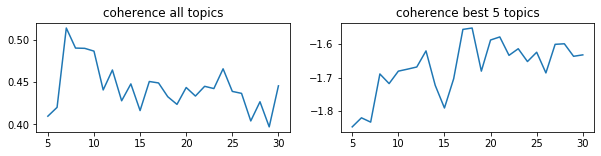

In [68]:
data = read_lda_data("lda-202003.txt")
make_lda_graphs(data)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda, texts=tokenized_tweets, dictionary=common_dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

In [ ]:
coherence_model_lda = CoherenceModel(topics=[["avondklok"],["scholen"],["ziekenhuizen"],["vaccin"],["test"],["maatregelen"]], texts=tokenized_tweets, dictionary=common_dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

In [ ]:
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:15]:
    print(score, end=" ")
    for id_ in list_:
        print(common_dictionary[int(id_[1])], end=" ")
    print()

In [ ]:
lda = LdaModel(common_corpus, num_topics=10)
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:5]:
    print(score)

In [ ]:
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:5]:
    print(score, end=" ")
    for id_ in list_:
        print(common_dictionary[int(id_[1])], end=" ")
    print()

In [ ]:
lda = LdaModel(common_corpus, num_topics=20)
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:5]:
    print(score)

In [ ]:
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:5]:
    print(score, end=" ")
    for id_ in list_:
        print(common_dictionary[int(id_[1])], end=" ")
    print()

In [ ]:
lda = LdaModel(common_corpus, num_topics=50)
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:5]:
    print(score)

In [ ]:
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary)[:5]:
    print(score, end=" ")
    for id_ in list_:
        print(common_dictionary[int(id_[1])], end=" ")
    print()

In [ ]:
for i in range(0, 5):
    print(f"{i}:", end=" ")
    for id_, score in lda.show_topic(i, topn=15):
        print(common_dictionary[int(id_)], end=" ")
    print()

In [ ]:
for i in range(0, len(lda.get_topics())):
    print(f"{i}:", end=" ")
    for id_, score in lda.show_topic(i, topn=15):
        print(common_dictionary[int(id_)], end=" ")
    print()

In [ ]:
for i in range(0, 10):
    print(f"{i}:", end=" ")
    for id_, score in lda.show_topic(i, topn=15):
        print(common_dictionary[int(id_)], end=" ")
    print()

In [ ]:
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary):
    print(score)

In [ ]:
for list_, score in lda.top_topics(corpus=common_corpus, dictionary=common_dictionary):
    print(score)

In [ ]:
lda.print_topic(0)

In [ ]:
lda.get_topics()[0]

In [ ]:
lda.get_term_topics(58)

In [ ]:
tokenized_tweets[0]

In [ ]:
len(lda.get_topics())